# Clasificador de Señales de Tránsito con ResNet50

Este proyecto implementa un clasificador de señales de tránsito utilizando Transfer Learning con la arquitectura ResNet50 pre-entrenada en ImageNet.

## Características del Dataset

- **Total de imágenes**: 39,209 en entrenamiento
- **Número de clases**: 43 tipos de señales de tránsito
- **Organización**: Estructura de carpetas por clase

[Link del Dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)

## Tabla de Contenidos

1. Configuración Inicial
2. Preparación de Datos
3. Construcción del Modelo
4. Entrenamiento
5. Evaluación y Predicción


## 1. Configuración Inicial

### Imports y Dependencias

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import random
import json
import os

**Librerías utilizadas:**
- **TensorFlow/Keras**: Framework principal para deep learning
- **ResNet50**: Modelo pre-entrenado de 50 capas para transfer learning
- **ImageDataGenerator**: Para carga y procesamiento de imágenes
- **Matplotlib**: Visualización de resultados

### Parámetros de Configuración

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CARPETA_ENTRENAMIENTO = "dataset/Train"
CARPETA_PRUEBAS = "dataset/Test"
CARPETA_META = "dataset/Meta"

**Configuración del proyecto:**
- **IMAGE_SIZE**: Tamaño estándar requerido por ResNet50 (224x224 píxeles)
- **BATCH_SIZE**: 32 imágenes procesadas simultáneamente
- **Rutas del dataset**: Organización en carpetas Train/Test/Meta

## 2. Preparación de Datos

### Generador de Datos de Entrenamiento

In [3]:
# Data Augmentation para mejorar generalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,      # Rotación ±15°
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1, # Desplazamiento vertical
    zoom_range=0.1,         # Zoom ±10%
    validation_split=0.2    # 20% para validación
)

**Características**

- **Normalización**: Escala los píxeles de [0, 255] a [0, 1]
- **Aplica transformaciones** como rotaciones, desplazamientos y zoom.
- **Divide** automáticamente el 20% para validación.

In [4]:
# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    CARPETA_ENTRENAMIENTO,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True
)

# Generador de validación
val_generator = train_datagen.flow_from_directory(
    CARPETA_ENTRENAMIENTO,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


**Generadores de imágenes:**

- Cargan automáticamente las imágenes desde carpetas.
- Ajustan tamaño, batch y formato para ResNet.
- Crean subdivisión training/validation usando subset.
- `NUM_CLASSES` detecta cuántas clases hay en el dataset.

## 3. Construcción del Modelo

### Arquitectura con Transfer Learning

In [5]:
# Cargar ResNet50 pre-entrenada (sin capas superiores)
base_model = ResNet50(
    weights="imagenet",      # Pesos pre-entrenados en ImageNet
    include_top=False,       # Excluir capas de clasificación
    input_shape=(224, 224, 3)
)

**Carga del modelo base:**
- Se usa ResNet50 preentrenada en ImageNet.
- Se quitan las capas de clasificación (include_top=False).

In [6]:
# Añadir capas personalizadas para nuestro problema
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.3, name='dropout_1')(x)  # Regularización
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(0.3, name='dropout_2')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

# Modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

**Capas personalizadas del modelo:**

- GAP: reduce dimensionalidad y evita sobreajuste.
- Dropout: regulariza y reduce overfitting.
- Dense 256 + ReLU: capa plenamente conectada para aprender patrones específicos.
- Softmax: salida final que clasifica entre las clases del dataset.

### Compilación del Modelo

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

**Compilación:**

- Adam: optimizador rápido y estable.
- Categorical Crossentropy: usada para clasificación multiclase.
- Métricas:
    - accuracy: exactitud general.
    - top_k_accuracy: mide si la clase correcta está entre las K más probables.

## 4. Entrenamiento

### Configuración del Callbacks

In [ ]:
callbacks = [
    ModelCheckpoint(
        'mejor_modelo.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

**Callbacks:**
- ModelCheckpoint: guarda el mejor modelo según val_accuracy.
- EarlyStopping: detiene entrenamiento si el modelo deja de mejorar → evita overfitting y ahorra tiempo.
- restore_best_weights: mantiene los mejores pesos obtenidos.

### Entrenamiento Inicial

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

model.save("modelo_final.keras")

class_names = list(train_generator.class_indices.keys())
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

**Proceso:**
- Entrena por 5 épocas completas
- Guarda progreso con el callback
- Genera archivo final `modelo_final.keras`
- Se guardan los nombres de las clases para usarlos en predicciones futuras.

### Entrenamiento Continuado (Opcional)

In [ ]:
# Cargar modelo guardado
model = tf.keras.models.load_model("mejor_modelo.keras")

# Continuar entrenamiento
history_continuado = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,  # Época final
        initial_epoch=1,  # Época inicial (desde donde continúa)
        callbacks=callbacks,
        verbose=1
    )

model.save("modelo_final.keras")

class_names = list(train_generator.class_indices.keys())
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

**Reanudación del entrenamiento:**

- Se carga el mejor modelo previamente guardado.
- Continúa desde una época específica usando initial_epoch.
- Permite seguir el entrenamiento sin perder el progreso anterior.

### Resultado del entrenamiento:

```
Epoch 5: val_accuracy improved from 0.93457 to 0.97181, saving model to mejor_modelo.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 2600s 3s/step
- accuracy: 0.9884
- loss: 0.0425
- top_k_categorical_accuracy: 0.9992
    - val_accuracy: 0.9718
    - val_loss: 0.1062
    - val_top_k_categorical_accuracy: 0.9953

## 5. Evaluación y Predicción

### Sistema de Prueba Automático

#### 5.1 Selección Aleatoria de Imagen

In [8]:
def escoger_imagen_aleatoria(carpeta_pruebas):
    extensiones = (".jpg", ".jpeg", ".png")
    imagenes = [f for f in os.listdir(carpeta_pruebas)
                if f.lower().endswith(extensiones)]

    if not imagenes:
        raise ValueError("No hay imágenes en la carpeta de pruebas.")

    imagen_aleatoria = random.choice(imagenes)
    ruta_imagen = os.path.join(carpeta_pruebas, imagen_aleatoria)

    return ruta_imagen

**Funcionalidad:**
- Busca todas las imágenes en carpeta Test
- Soporta formatos JPG, JPEG, PNG
- Selecciona una imagen al azar para prueba

#### 5.2 Predicción de Imagen

In [9]:
def predecir(model, ruta_imagen, class_names):

    img_bytes = tf.io.read_file(ruta_imagen)
    img = tf.image.decode_image(img_bytes, channels=3)

    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0

    img = tf.expand_dims(img, axis=0)

    pred = model.predict(img, verbose=0)
    clase_idx = tf.argmax(pred[0]).numpy()
    clase_predicha = class_names[clase_idx]

    return clase_predicha


**Pasos del proceso:**
1. **Carga**: Redimensiona a 224x224
2. **Normalización**: Escala píxeles [0,1]
3. **Batch dimension**: Añade dimensión para el modelo
4. **Predicción**: Obtiene probabilidades de todas las clases
5. **Selección**: Escoge la clase con mayor probabilidad

#### 5.3 Visualización de Resultados

In [10]:
def obtener_imagen_meta(carpeta_meta, clase_predicha):
    posibles_ext = [".jpg", ".jpeg", ".png"]

    for ext in posibles_ext:
        ruta = os.path.join(carpeta_meta, clase_predicha + ext)
        if os.path.exists(ruta):
            return ruta

    return None

def mostrar_comparacion(ruta_prueba, ruta_meta, clase_predicha):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Imagen de prueba
    img1 = tf.keras.utils.load_img(ruta_prueba)
    ax[0].imshow(img1)
    ax[0].set_title(f"Imagen de Prueba\n{os.path.basename(ruta_prueba)}")
    ax[0].axis("off")

    # Imagen meta (referencia)
    if ruta_meta:
        img2 = tf.keras.utils.load_img(ruta_meta)
        ax[1].imshow(img2)
        ax[1].set_title(f"Imagen META\nClase: {clase_predicha}")
    else:
        ax[1].text(0.5, 0.5, "No existe imagen-meta",
                   ha="center", va="center", fontsize=12)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

**Sistema de comparación:**
- Busca imagen de referencia en carpeta Meta
- Muestra lado a lado: imagen de prueba vs. señal de referencia
- Permite verificación visual de la predicción

#### 5.4 Función Principal de Prueba

In [11]:
def prueba_completa(model, carpeta_pruebas, carpeta_meta, class_names):
    # 1. Elegir imagen aleatoria
    imagen_prueba = escoger_imagen_aleatoria(carpeta_pruebas)

    # 2. Obtener predicción
    clase = predecir(model, imagen_prueba, class_names)

    # 3. Buscar imagen meta
    ruta_meta = obtener_imagen_meta(carpeta_meta, clase)

    # 4. Mostrar resultado
    mostrar_comparacion(imagen_prueba, ruta_meta, clase)

### Ejecución de Pruebas

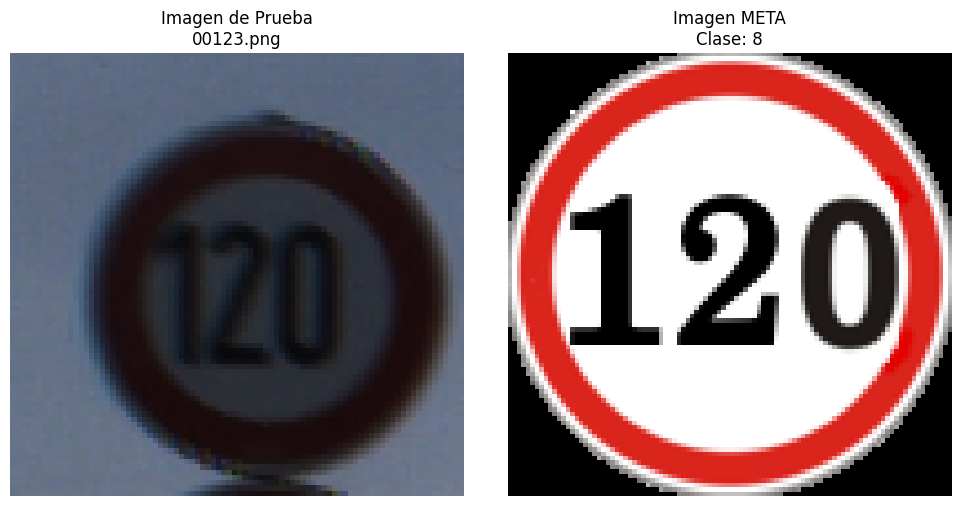

In [14]:
# Cargar el modelo
model = tf.keras.models.load_model("modelo_final.keras")

# Cargar los nombres de las clases
with open("class_names.json", "r") as f:
    class_names = json.load(f)

prueba_completa(model, CARPETA_PRUEBAS, CARPETA_META, class_names)